In [2]:
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv

--2021-06-04 11:07:11--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11219474 (11M) [text/plain]
Saving to: ‘equipment_failure_data_1.csv’

equipment_failure_d 100%[===================>]  10.70M  31.6MB/s    in 0.3s    

2021-06-04 11:07:12 (31.6 MB/s) - ‘equipment_failure_data_1.csv’ saved [11219474/11219474]



In [3]:
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv

--2021-06-04 11:07:19--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11762512 (11M) [text/plain]
Saving to: ‘equipment_failure_data_2.csv’

equipment_failure_d 100%[===================>]  11.22M  57.7MB/s    in 0.2s    

2021-06-04 11:07:20 (57.7 MB/s) - ‘equipment_failure_data_2.csv’ saved [11762512/11762512]



In [4]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
#read
df = pd.read_csv('equipment_failure_data_1.csv', header=0,parse_dates=['DATE'])
df2 = pd.read_csv('equipment_failure_data_2.csv', header=0,parse_dates=['DATE'])

In [6]:
#concatenate
data = pd.concat([df,df2])
data.reset_index(inplace=True, drop=True)

In [7]:
#extract day year month
data['YEAR']=data.DATE.dt.year
data['MONTH']=data.DATE.dt.month
data['DAY']=data.DATE.dt.day
data = data.drop(['DATE'],1)
data.head()

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
0,100001,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,2014,12,2
1,100001,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0,0.0,881,2014,12,3
2,100001,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0,0.0,882,2014,12,4
3,100001,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0,0.0,883,2014,12,5
4,100001,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0,0.0,884,2014,12,6


In [8]:
'''#one-hot-encoding
dummies = pd.get_dummies(data['MANUFACTURER'])
data = pd.concat([data,dummies],1)
data = data.drop(['MANUFACTURER'],1)'''

"#one-hot-encoding\ndummies = pd.get_dummies(data['MANUFACTURER'])\ndata = pd.concat([data,dummies],1)\ndata = data.drop(['MANUFACTURER'],1)"

In [9]:
#label encoding
from sklearn.preprocessing import LabelEncoder
to_be_encoded = ['ID','MANUFACTURER','REGION_CLUSTER','MAINTENANCE_VENDOR']
for i in to_be_encoded:
  data[i] = LabelEncoder().fit_transform(data[i])

In [10]:
#check if all machines failed
data.EQUIPMENT_FAILURE.sum()

421

In [11]:
failed_id = data[data['EQUIPMENT_FAILURE'] == 1]['ID']
failed_id

143         0
1452        2
1974        5
2882        6
2940        9
         ... 
304586    413
305182    417
306127    418
306848    419
307679    420
Name: ID, Length: 421, dtype: int64

In [11]:
#creating a function inputing data and id to see failure in sensor data
def plotfail(data,id,sensor):
  ser = data.loc[data['ID']==id]
  plt.plot(ser[sensor])
  failed_index = ser[ser['EQUIPMENT_FAILURE'] == 1]['ID'].index
  plt.scatter(failed_index,ser['EQUIPMENT_FAILURE'][failed_index],color='red')

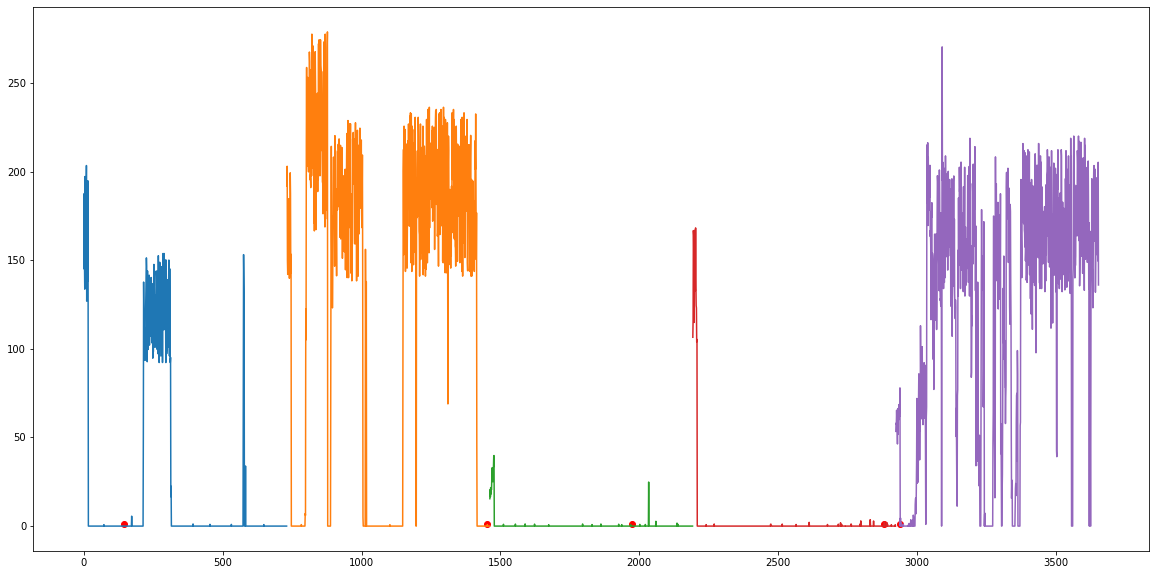

In [12]:
#plotting some machines side by side to see where fail occurs
plt.figure(figsize=(20,10))
for i in failed_id[0:5]:
  plotfail(data,i,'S17')

(array([4.12930e+04, 1.14014e+05, 2.15060e+04, 6.55620e+04, 5.84650e+04,
        6.90300e+03, 3.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([ 0.   ,  5.904, 11.808, 17.712, 23.616, 29.52 , 35.424, 41.328,
        47.232, 53.136, 59.04 ]),
 <a list of 10 Patch objects>)

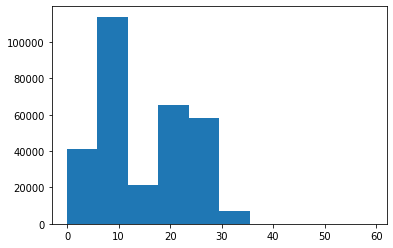

In [13]:
#histogram of all S15 sensor values, looks skewed may have to transform ones like these later
plt.hist(data.S15)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


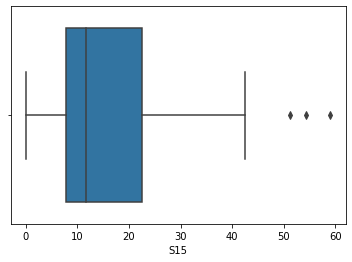

In [14]:
sns.boxplot(data.S15)
#outlier search

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


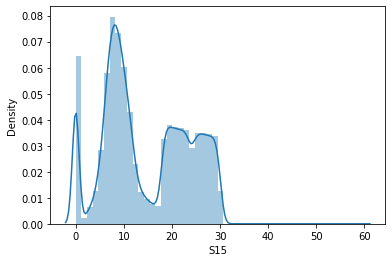

In [15]:
#further EDA On S15
sns.distplot(data.S15)

In [16]:
#extreme sensor values
#can be added as a categorical variable, removed or smoothened later on
extremeS15 = data[data.S15>35]
extremeS15

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
2764,6,7,4,2,2,51.2256,0.77,24.548148,5228.592593,4.8380,33.3,50.3,0,57.482963,1331,2016,6,25
4442,11,1,4,0,4,41.6712,0.00,29.442500,2620.375000,7.5816,1.3,14.8,0,0.000000,796,2015,1,27
4443,11,1,4,0,4,42.5304,0.00,29.850000,2657.000000,8.0410,1.3,14.8,0,56.070000,797,2015,1,28
98282,289,1,6,6,1,40.6992,10.56,33.115926,2947.296296,6.7670,4.6,51.9,0,71.474074,5748,2015,10,26
175373,64,0,3,5,5,59.0400,0.00,59.840000,4548.000000,9.8318,0.0,5.6,0,1.890000,684,2016,9,26
260292,282,3,6,2,5,54.3744,0.00,38.430000,11720.000000,7.1519,14.8,1006.9,0,1604.080000,76,2015,1,27
304197,413,6,5,8,5,37.0656,0.00,37.378500,4448.150000,11.5245,0.6,117.5,0,234.809500,1081,2015,3,13
304198,413,6,5,8,5,38.5632,0.00,37.422632,4453.421053,9.3575,0.6,117.5,0,234.872632,1082,2015,3,14


In [17]:
data.head(1)

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
0,0,6,6,8,1,11.088,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,2014,12,2


In [18]:
#EDA for variable interactions
#sns.pairplot(data)

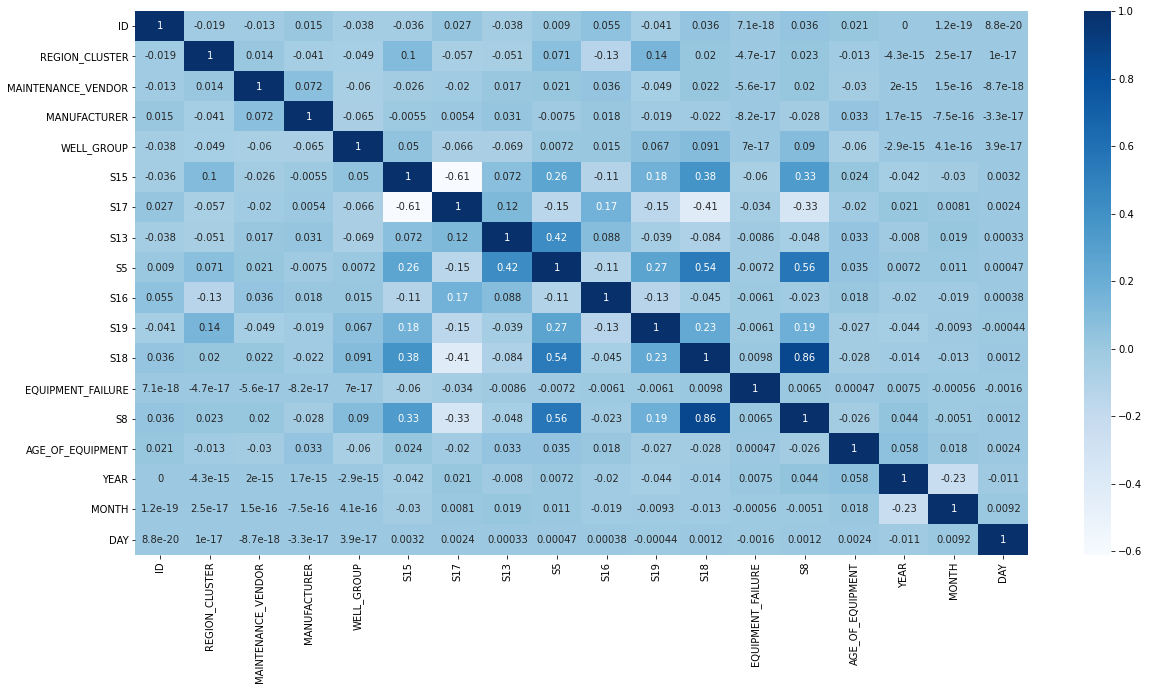

In [19]:
#Correlation heatmap - sensors have some intercorrelations which was expected
correlation_matrix = data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")

In [20]:
#lets try a simple baseline model but first we need to deal with class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
data.EQUIPMENT_FAILURE.value_counts()

0    307330
1       421
Name: EQUIPMENT_FAILURE, dtype: int64

In [22]:
421/307330*100

0.136986301369863

In [23]:
#We deal with the imbalance by expanding the fails by adding the 30 days prior
window = 30
#a function to add 1s in front of the fail labels to extend the idea of failure
def changeToOne(arr,window):
    curr = len(arr)-1
    while curr>=0:
        if arr[curr]==1:
            curr -= 1
            for _ in range(window):
                arr[curr]=1
                curr -= 1
        else:
            curr -=1

In [24]:
#changeToOne(data['EQUIPMENT_FAILURE'],30)

In [25]:
data['EQUIPMENT_FAILURE'].value_counts()

0    307330
1       421
Name: EQUIPMENT_FAILURE, dtype: int64

In [26]:
#imbalance is decreased but still needs sampling
13051/294700*100

4.428571428571428

In [14]:
ids = data.drop_duplicates(subset='ID')
ids = ids[['ID']]
ids.shape

(421, 1)

In [15]:
#train test validation splitting based on probabilities against imbalance 35%train 35%test 30%valid
np.random.seed(7)
ids['rv'] = (np.random.randint(0,10000,len(ids)))/10000
ids = ids[['ID','rv']]

ids['SETS'] = np.where(((ids.rv <= 0.35)), 'TRAINING', np.where(((ids.rv <= 0.65)), 'VALIDATION', 'TESTING'))
summed = ids.groupby(['SETS'])['rv'].count()
print(summed, summed/sum(summed))

SETS
TESTING       145
TRAINING      147
VALIDATION    129
Name: rv, dtype: int64 SETS
TESTING       0.344418
TRAINING      0.349169
VALIDATION    0.306413
Name: rv, dtype: float64


In [16]:
data=data.sort_values(by=['ID'], ascending=[True])
ids=ids.sort_values(by=['ID'], ascending=[True])
data =data.merge(ids, on=['ID'], how='inner')

In [17]:
instance_sum = data.groupby(['SETS'])['rv'].count()
instance_sum

SETS
TESTING       105995
TRAINING      107457
VALIDATION     94299
Name: rv, dtype: int64

In [31]:
data[data['EQUIPMENT_FAILURE']==1].groupby(['SETS'])['rv'].count()

SETS
TESTING       145
TRAINING      147
VALIDATION    129
Name: rv, dtype: int64

In [32]:
data

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY,rv,SETS
0,0,6,6,8,1,11.0880,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.00,880,2014,12,2,0.9412,TESTING
1,0,6,6,8,1,18.9600,0.000000,38.87,3459.0,10.047300,1.3,36.600000,0,34.37,1363,2016,3,29,0.9412,TESTING
2,0,6,6,8,1,29.0400,0.000000,37.36,3325.0,10.235100,1.4,36.000000,0,32.37,1364,2016,3,30,0.9412,TESTING
3,0,6,6,8,1,18.0000,0.000000,38.81,3454.0,8.544900,1.4,36.100000,0,34.44,1365,2016,3,31,0.9412,TESTING
4,0,6,6,8,1,26.1600,0.000000,39.47,3513.0,10.986300,1.4,36.300000,0,33.26,1366,2016,4,1,0.9412,TESTING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307746,420,2,7,2,7,4.7808,117.450000,46.67,3127.0,9.564800,0.7,2.500000,0,2.14,325,2015,8,4,0.1798,TRAINING
307747,420,2,7,2,7,5.6448,110.700000,47.88,3208.0,11.126400,0.7,2.400000,0,2.63,326,2015,8,5,0.1798,TRAINING
307748,420,2,7,2,7,4.4352,143.100000,46.63,3124.0,8.473800,0.7,2.400000,0,2.01,327,2015,8,6,0.1798,TRAINING
307749,420,2,7,2,7,5.5872,167.500000,46.45,3112.0,7.320000,0.4,2.200000,0,2.09,329,2015,8,8,0.1798,TRAINING


In [33]:
datacopy = data

In [34]:
#adding min max median to sensor data is apparently significant as in signalization theory
#add also moving average

In [35]:
#one hot encoded
'''train = data[data.SETS == 'TRAINING'].iloc[:,:16]
train_test = data[data.SETS != 'VALIDATION'].iloc[:,:16]
valid = data[data.SETS == 'VALIDATION'].iloc[:,:16]
test = data[data.SETS == 'TESTING'].iloc[:,:16]
total = data.iloc[:,:16]'''

"train = data[data.SETS == 'TRAINING'].iloc[:,:16]\ntrain_test = data[data.SETS != 'VALIDATION'].iloc[:,:16]\nvalid = data[data.SETS == 'VALIDATION'].iloc[:,:16]\ntest = data[data.SETS == 'TESTING'].iloc[:,:16]\ntotal = data.iloc[:,:16]"

In [18]:
#label encoded
train = data[data.SETS == 'TRAINING'].iloc[:,:-2]
train_test = data[data.SETS != 'VALIDATION'].iloc[:,:-2]
valid = data[data.SETS == 'VALIDATION'].iloc[:,:-2]
test = data[data.SETS == 'TESTING'].iloc[:,:-2]
total = data.iloc[:,:-2]

In [37]:
train

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
1462,2,2,3,3,1,19.9200,0.00,35.65,3173.0,7.6500,0.0,2.9,0,124.41,765,2015,12,2
1463,2,2,3,3,1,9.5832,210.56,35.34,3145.0,8.4524,0.9,0.2,0,0.00,883,2016,3,29
1464,2,2,3,3,1,7.2072,213.57,34.75,3093.0,7.2556,0.9,0.3,0,0.01,884,2016,3,30
1465,2,2,3,3,1,9.2664,154.16,35.63,3171.0,8.5905,0.9,0.2,0,40.76,885,2016,3,31
1466,2,2,3,3,1,8.7120,157.92,35.93,3198.0,5.6848,0.9,0.2,0,40.86,886,2016,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307746,420,2,7,2,7,4.7808,117.45,46.67,3127.0,9.5648,0.7,2.5,0,2.14,325,2015,8,4
307747,420,2,7,2,7,5.6448,110.70,47.88,3208.0,11.1264,0.7,2.4,0,2.63,326,2015,8,5
307748,420,2,7,2,7,4.4352,143.10,46.63,3124.0,8.4738,0.7,2.4,0,2.01,327,2015,8,6
307749,420,2,7,2,7,5.5872,167.50,46.45,3112.0,7.3200,0.4,2.2,0,2.09,329,2015,8,8


In [19]:
train_features = train.drop(['EQUIPMENT_FAILURE'],1)
train_label = train.EQUIPMENT_FAILURE

In [39]:
train_features

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
1462,2,2,3,3,1,19.9200,0.00,35.65,3173.0,7.6500,0.0,2.9,124.41,765,2015,12,2
1463,2,2,3,3,1,9.5832,210.56,35.34,3145.0,8.4524,0.9,0.2,0.00,883,2016,3,29
1464,2,2,3,3,1,7.2072,213.57,34.75,3093.0,7.2556,0.9,0.3,0.01,884,2016,3,30
1465,2,2,3,3,1,9.2664,154.16,35.63,3171.0,8.5905,0.9,0.2,40.76,885,2016,3,31
1466,2,2,3,3,1,8.7120,157.92,35.93,3198.0,5.6848,0.9,0.2,40.86,886,2016,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307746,420,2,7,2,7,4.7808,117.45,46.67,3127.0,9.5648,0.7,2.5,2.14,325,2015,8,4
307747,420,2,7,2,7,5.6448,110.70,47.88,3208.0,11.1264,0.7,2.4,2.63,326,2015,8,5
307748,420,2,7,2,7,4.4352,143.10,46.63,3124.0,8.4738,0.7,2.4,2.01,327,2015,8,6
307749,420,2,7,2,7,5.5872,167.50,46.45,3112.0,7.3200,0.4,2.2,2.09,329,2015,8,8


In [40]:
cat_features = [['ID',	'REGION_CLUSTER',	'MAINTENANCE_VENDOR', 'MANUFACTURER',	'WELL_GROUP']]

In [41]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
#smx = SMOTENC(random_state=12,  categorical_features=[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13,14])
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 3, 4, 14, 15, 16])
x_res, y_res = smx.fit_sample(train_features, train_label.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [ ]:
x = pd.DataFrame(x_res)
y = pd.DataFrame(y_res)
x.columns = train_features.columns
y.columns = ['target']

In [ ]:
y.mean(axis=0)

In [ ]:
balanced_data = pd.concat([x,y],1)
balanced_data

In [20]:
#scaling
from sklearn.preprocessing import StandardScaler
def scale(dataset,target):
  dataset_sc = pd.DataFrame(StandardScaler().fit_transform(dataset.drop(target,1)))
  return pd.concat([dataset_sc,dataset.target],axis=1)

In [21]:
def data2xy(dataset,target):
  x = dataset.drop(target,1)
  y = dataset[target]
  return x,y

In [ ]:
X, y = data2xy(total,'EQUIPMENT_FAILURE')
X_train = balanced_data.drop(['target'],1)
y_train = balanced_data.target.values
X_valid, y_valid = data2xy(valid,'EQUIPMENT_FAILURE')
X_test, y_test = data2xy(test,'EQUIPMENT_FAILURE')

In [ ]:
#TRAINING
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#TESTING
unique, counts = np.unique(y_valid, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#VALIDATION
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#A dumb prediction consisting of zeros for a baseline
baseline_valid = np.zeros(y_valid.shape)
baseline_test = np.zeros(y_test.shape)
print(accuracy_score(y_valid, baseline_valid),accuracy_score(y_test, baseline_test))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
!pip install catboost

In [ ]:
X_train

In [ ]:
intlist = list(set(X_train.columns) - set(X_train.iloc[:,5:-3].columns))

In [ ]:
X_train[intlist] = X_train[intlist].astype(int)
X_train.dtypes

In [ ]:
from catboost import CatBoostClassifier, Pool
model = MLPClassifier()
#RandomForestClassifier()
#CatBoostClassifier(cat_features =intlist)
#pool = Pool(X_train, y_train, )

In [ ]:
# we should be training on the smoted balanced data and predicting on imbalanced unseen data
# anything below 0.957 is useless
model.fit(X_train,y_train)#, eval_set=(X_test,y_test))
pred = model.predict(X_valid)
pred_prob = model.predict_proba(X_valid)
print(classification_report(y_valid, pred))
print(accuracy_score(y_valid, pred))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid,pred))

In [ ]:
pred_prob

In [ ]:
X_train.columns

In [ ]:
model.fit(X_train,y_train)
pred = model.predict(X_test)
pred_prob = model.predict_proba(X_test)
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

In [ ]:
X_train

In [ ]:
def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0))
        return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
import pywt
def denoise(x,y):
    (ca, cd) = pywt.dwt(x, "haar")
    cat = pywt.threshold(ca, y * np.std(ca), mode="soft")
    cdt = pywt.threshold(cd, y * np.std(cd), mode="soft")
    tx = pywt.idwt(cat, cdt, "haar")
    return tx

In [ ]:
def adf_test(series, signif=0.05):
    dftest = adfuller(series, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags', '# Observations'])
    #for key, value in dftest[4].items():
    #    adf['Critical Value (%s)' % key] = value

    p = adf['p-value']
    if p <= signif:
        print(f"ADF TEST: Series is Stationary")
    else:
        print(f"ADF TEST: Series is Non-Stationary")
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw, nlags='auto')
    print(f'KPSS TEST: The series is {"not " if p_value < 0.05 else ""}stationary')

In [ ]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    # rolling statistics plot
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
def check(timeseries):
    adf_test(timeseries)
    kpss_test(timeseries)

In [ ]:
'''!pip uninstall protobuf python3-protobuf
!pip install --upgrade pip
!pip install --upgrade protobuf'''

SWITCHING TO DEEP LEARNING AS ML WAS INSUFFICIENT 

In [ ]:
#we need a multivariate LSTM

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
import keras.backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

In [43]:
total.head(1)

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,YEAR,MONTH,DAY
0,0,6,6,8,1,11.088,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.0,880,2014,12,2


In [23]:
train = total.drop(['YEAR','MONTH','DAY'],1)

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train.values)

In [47]:
train

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,0,6,6,8,1,11.0880,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.00,880
1,0,6,6,8,1,18.9600,0.000000,38.87,3459.0,10.047300,1.3,36.600000,0,34.37,1363
2,0,6,6,8,1,29.0400,0.000000,37.36,3325.0,10.235100,1.4,36.000000,0,32.37,1364
3,0,6,6,8,1,18.0000,0.000000,38.81,3454.0,8.544900,1.4,36.100000,0,34.44,1365
4,0,6,6,8,1,26.1600,0.000000,39.47,3513.0,10.986300,1.4,36.300000,0,33.26,1366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307746,420,2,7,2,7,4.7808,117.450000,46.67,3127.0,9.564800,0.7,2.500000,0,2.14,325
307747,420,2,7,2,7,5.6448,110.700000,47.88,3208.0,11.126400,0.7,2.400000,0,2.63,326
307748,420,2,7,2,7,4.4352,143.100000,46.63,3124.0,8.473800,0.7,2.400000,0,2.01,327
307749,420,2,7,2,7,5.5872,167.500000,46.45,3112.0,7.320000,0.4,2.200000,0,2.09,329


In [48]:
[train[i].nunique() for i in train.columns]

[421,
 8,
 8,
 10,
 8,
 27139,
 13376,
 35865,
 40905,
 31575,
 1299,
 20130,
 2,
 84100,
 14322]

In [49]:
train.shape

(307751, 15)

In [50]:
scaled.shape

(307751, 15)

In [51]:
pd.DataFrame(scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.857143,0.857143,0.888889,0.000000,0.187805,0.056827,0.066353,0.066348,0.342556,0.003718,0.005928,0.0,0.007910,0.058009
1,0.0,0.857143,0.857143,0.888889,0.000000,0.321138,0.000000,0.065560,0.065552,0.408427,0.002544,0.008816,0.0,0.024398,0.089848
2,0.0,0.857143,0.857143,0.888889,0.000000,0.491870,0.000000,0.063013,0.063013,0.416061,0.002740,0.008671,0.0,0.023439,0.089914
3,0.0,0.857143,0.857143,0.888889,0.000000,0.304878,0.000000,0.065459,0.065458,0.347354,0.002740,0.008695,0.0,0.024432,0.089980
4,0.0,0.857143,0.857143,0.888889,0.000000,0.443089,0.000000,0.066572,0.066576,0.446598,0.002740,0.008743,0.0,0.023865,0.090046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307746,1.0,0.285714,1.000000,0.222222,0.857143,0.080976,0.045959,0.078716,0.059261,0.388813,0.001370,0.000602,0.0,0.008937,0.021424
307747,1.0,0.285714,1.000000,0.222222,0.857143,0.095610,0.043318,0.080757,0.060796,0.452293,0.001370,0.000578,0.0,0.009172,0.021490
307748,1.0,0.285714,1.000000,0.222222,0.857143,0.075122,0.055996,0.078649,0.059204,0.344463,0.001370,0.000578,0.0,0.008875,0.021556
307749,1.0,0.285714,1.000000,0.222222,0.857143,0.094634,0.065544,0.078345,0.058976,0.297561,0.000783,0.000530,0.0,0.008913,0.021688


In [52]:
train[train['ID']==0]

,ID,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,0,6,6,8,1,11.0880,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0,0.00,880
1,0,6,6,8,1,18.9600,0.000000,38.87,3459.0,10.047300,1.3,36.600000,0,34.37,1363
2,0,6,6,8,1,29.0400,0.000000,37.36,3325.0,10.235100,1.4,36.000000,0,32.37,1364
3,0,6,6,8,1,18.0000,0.000000,38.81,3454.0,8.544900,1.4,36.100000,0,34.44,1365
4,0,6,6,8,1,26.1600,0.000000,39.47,3513.0,10.986300,1.4,36.300000,0,33.26,1366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,6,6,8,1,8.3520,103.320000,39.06,3476.0,8.911200,3.0,18.500000,0,10.80,1125
727,0,6,6,8,1,6.3984,94.710000,39.38,3505.0,7.781800,2.4,18.400000,0,10.58,1128
728,0,6,6,8,1,6.2496,116.850000,39.88,3549.0,10.689800,3.0,18.800000,0,13.15,1123
729,0,6,6,8,1,7.7376,140.220000,39.56,3521.0,8.532000,3.0,18.700000,0,13.19,1122


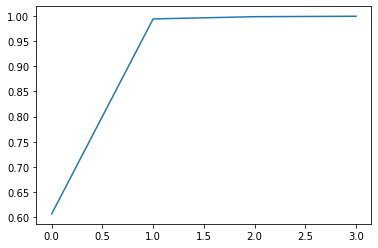

In [26]:
#I realized that this will be a huge memory burden to have over million entry matrix so i want to PCA first which is beneficial either way
# the steep curve shows one column explains over 95% of the variance indicating our dataset is pretty useless
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
plt.plot(exp_var_cumul)

In [27]:
#So i decided to downsize to only two columns
pca = PCA(n_components=2)
trainpca = pca.fit_transform(scaled)
trainpca = pd.DataFrame(trainpca)
trainpca.columns = ['pc1','pc2']

In [28]:
#split 300train 121 test
X_train = trainpca.iloc[:731*300,:]
X_test = trainpca.iloc[731*300:,:]
print(X_train.shape, X_test.shape)

(219300, 2) (88451, 2)


In [29]:
#we want to feed t-N steps up to failure to predict the t step and then we will classify that row
reframed = series_to_supervised(X_train, 730, 1)

In [69]:
reframed.head(1)

,var1(t-730),var2(t-730),var1(t-729),var2(t-729),var1(t-728),var2(t-728),var1(t-727),var2(t-727),var1(t-726),var2(t-726),var1(t-725),var2(t-725),var1(t-724),var2(t-724),var1(t-723),var2(t-723),var1(t-722),var2(t-722),var1(t-721),var2(t-721),var1(t-720),var2(t-720),var1(t-719),var2(t-719),var1(t-718),var2(t-718),var1(t-717),var2(t-717),var1(t-716),var2(t-716),var1(t-715),var2(t-715),var1(t-714),var2(t-714),var1(t-713),var2(t-713),var1(t-712),var2(t-712),var1(t-711),var2(t-711),...,var1(t-19),var2(t-19),var1(t-18),var2(t-18),var1(t-17),var2(t-17),var1(t-16),var2(t-16),var1(t-15),var2(t-15),var1(t-14),var2(t-14),var1(t-13),var2(t-13),var1(t-12),var2(t-12),var1(t-11),var2(t-11),var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
730,0.75173,0.3051,0.74935,0.308776,0.745765,0.315785,0.749632,0.310497,0.746838,0.312507,0.74621,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.318505,0.748484,0.313561,0.749778,0.306284,0.74619,0.31646,0.7456,0.31393,0.746505,0.316987,0.749031,0.313383,...,0.753665,0.299357,0.753519,0.300566,0.753789,0.300726,0.752908,0.301233,0.752717,0.302013,0.752633,0.316865,0.753569,0.29758,0.753154,0.300644,0.753711,0.297614,0.753358,0.299614,0.753145,0.304339,0.753721,0.303376,0.753127,0.302243,0.753015,0.302513,0.752813,0.305693,0.753035,0.302632,0.753693,0.303031,0.753858,0.298234,0.753261,0.302752,0.753587,0.301247


In [30]:
y_train = reframed.iloc[:,-2:]
reframed = reframed.drop(['var1(t)','var2(t)'],1)
reframed

,var1(t-730),var2(t-730),var1(t-729),var2(t-729),var1(t-728),var2(t-728),var1(t-727),var2(t-727),var1(t-726),var2(t-726),var1(t-725),var2(t-725),var1(t-724),var2(t-724),var1(t-723),var2(t-723),var1(t-722),var2(t-722),var1(t-721),var2(t-721),var1(t-720),var2(t-720),var1(t-719),var2(t-719),var1(t-718),var2(t-718),var1(t-717),var2(t-717),var1(t-716),var2(t-716),var1(t-715),var2(t-715),var1(t-714),var2(t-714),var1(t-713),var2(t-713),var1(t-712),var2(t-712),var1(t-711),var2(t-711),...,var1(t-20),var2(t-20),var1(t-19),var2(t-19),var1(t-18),var2(t-18),var1(t-17),var2(t-17),var1(t-16),var2(t-16),var1(t-15),var2(t-15),var1(t-14),var2(t-14),var1(t-13),var2(t-13),var1(t-12),var2(t-12),var1(t-11),var2(t-11),var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
730,0.751730,0.305100,0.749350,0.308776,0.745765,0.315785,0.749632,0.310497,0.746838,0.312507,0.746210,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.318505,0.748484,0.313561,0.749778,0.306284,0.746190,0.316460,0.745600,0.313930,0.746505,0.316987,0.749031,0.313383,...,0.753552,0.302730,0.753665,0.299357,0.753519,0.300566,0.753789,0.300726,0.752908,0.301233,0.752717,0.302013,0.752633,0.316865,0.753569,0.297580,0.753154,0.300644,0.753711,0.297614,0.753358,0.299614,0.753145,0.304339,0.753721,0.303376,0.753127,0.302243,0.753015,0.302513,0.752813,0.305693,0.753035,0.302632,0.753693,0.303031,0.753858,0.298234,0.753261,0.302752
731,0.749350,0.308776,0.745765,0.315785,0.749632,0.310497,0.746838,0.312507,0.746210,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.318505,0.748484,0.313561,0.749778,0.306284,0.746190,0.316460,0.745600,0.313930,0.746505,0.316987,0.749031,0.313383,0.747028,0.313485,...,0.753665,0.299357,0.753519,0.300566,0.753789,0.300726,0.752908,0.301233,0.752717,0.302013,0.752633,0.316865,0.753569,0.297580,0.753154,0.300644,0.753711,0.297614,0.753358,0.299614,0.753145,0.304339,0.753721,0.303376,0.753127,0.302243,0.753015,0.302513,0.752813,0.305693,0.753035,0.302632,0.753693,0.303031,0.753858,0.298234,0.753261,0.302752,0.753587,0.301247
732,0.745765,0.315785,0.749632,0.310497,0.746838,0.312507,0.746210,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.318505,0.748484,0.313561,0.749778,0.306284,0.746190,0.316460,0.745600,0.313930,0.746505,0.316987,0.749031,0.313383,0.747028,0.313485,0.748824,0.313440,...,0.753519,0.300566,0.753789,0.300726,0.752908,0.301233,0.752717,0.302013,0.752633,0.316865,0.753569,0.297580,0.753154,0.300644,0.753711,0.297614,0.753358,0.299614,0.753145,0.304339,0.753721,0.303376,0.753127,0.302243,0.753015,0.302513,0.752813,0.305693,0.753035,0.302632,0.753693,0.303031,0.753858,0.298234,0.753261,0.302752,0.753587,0.301247,-0.341799,0.150702
733,0.749632,0.310497,0.746838,0.312507,0.746210,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.318505,0.748484,0.313561,0.749778,0.306284,0.746190,0.316460,0.745600,0.313930,0.746505,0.316987,0.749031,0.313383,0.747028,0.313485,0.748824,0.313440,0.746525,0.317068,...,0.753789,0.300726,0.752908,0.301233,0.752717,0.302013,0.752633,0.316865,0.753569,0.297580,0.753154,0.300644,0.753711,0.297614,0.753358,0.299614,0.753145,0.304339,0.753721,0.303376,0.753127,0.302243,0.753015,0.302513,0.752813,0.305693,0.753035,0.302632,0.753693,0.303031,0.753858,0.298234,0.753261,0.302752,0.753587,0.301247,-0.341799,0.150702,-0.343483,0.154721
734,0.746838,0.312507,0.746210,0.314327,0.747188,0.317649,0.746131,0.314534,0.746688,0.312548,0.745318,0.319963,0.748008,0.309027,0.749007,0.314132,0.746499,0.314262,0.746878,0.3

In [ ]:
#I want to train on first 300 machines then predict the unseen 121

In [71]:
y.shape

(218570, 2)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [31]:
X_train = reframed.values.reshape((-1, 730, 2))
#X_test = X_test.values.reshape((-1, 1, 2))
print(X_train.shape)#, y_train.shape, X_test.shape, y_test.shape)

(218570, 730, 2)


In [33]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=3, batch_size=10, verbose=3, shuffle=False)

Epoch 1/3
Epoch 2/3
Epoch 3/3


In [ ]:
reframed_test = series_to_supervised(X_test, 730, 1)

In [ ]:
X_test = reframed_test.values.reshape((-1,730,2))
print(X_test.shape)
pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

In [ ]:
#8GB colab ram crashed at this point but i'll complete the pipeline anyway for a later trial on a cloud.

In [ ]:
#Here we tried to see how well we predict the pca_data to further make classification on that.
#A correction to be made is changing the target from a fixed 731th data to the point of failure.
#TO DO LATER LIST
#analyze sensor series, denoise, add features like moving avg, std etc.
#try one hot encoding etc.
#try CNNs